# Detecting Generative AI Images vs. Original Images Using Neural Networks

The Generative AI vs Original images project is designed to address misinformation issue caused by generative AI. This project focuses on training a neural network to differentiate between generative AI images and original images. This addresses the growing challenge faced in domains such as digital forensics, misinformation detection, and intellectual property protection.

## Environment Setup

To implement this project we need python installed along with below module. Once installed import them.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

## Data loading and Preprocessing

Whenever we create a neural network model. we need three sets of data.

1. Training data, which is usually large because our model is trained using this data. The more the data for training the better the model accuracy.
2. Validation data, this is a part of training data which is set aside to validate the training accuracy.
3. Test data, our model is fed with this data to find it's accuracy.

In [22]:
# Set directories
train_dir = "data/train"
val_dir = "data/validate"
test_dir = "data/test"

In real time, not all images comes in same size. So, for our model to train and work properly we resize our image to a fixed dimension.

In [17]:
# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

### Data Augmentation

This is the process of generating more images from each and every image by rotating, zooming out, zooming in, rescaling and so on. It helps in increasing the dataset size. This is generally done to training dataset. But it can also be done to validation and test datasets.

In order to load image from the directories and prepare them for training, validation and testing we use ImageDataGenerator class

In [18]:
# Data Augmentation and Data Loaders
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [19]:
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

To generate batches of image data from the directories we use flow_from_directory function. This function will preprocess the image like resizing it based on given dimensions and batch_size is also given to it.

Our directory structure of datasets is as follows.
```
train/
    REAL/
        img1.jpg
        img2.jpg
    FAKE/
        img3.jpg
        img4.jpg

validate/
    REAL/
        img1.jpg
        img2.jpg
    FAKE/
        img3.jpg
        img4.jpg

test/
    REAL/
        img1.jpg
        img2.jpg
    FAKE/
        img3.jpg
        img4.jpg
```

In [20]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
)

Found 96060 images belonging to 2 classes.


In [23]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
)

Found 3940 images belonging to 2 classes.


In [24]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

Found 20000 images belonging to 2 classes.


## Building our model

Our neural network, a sequential model, has there Conv2D layer with relu as activation function. Followed by every Conv2D layer, we have a pooling layer. The output of Convolutional and pooling layer is given to a dense layer with 128 nodes. We use a dropout after this layer to make our network more effective. The final output layer is activated by sigmoid function.

We use Adam optimizer to compile our model along with binary cross entropy as loss function. We monitor accuracy through out process.

In [25]:
# Model Creation
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

/home/kirubakkar/anaconda3/envs/new_teachable/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-26 12:57:45.691503: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [27]:
# Compile the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

We train our model using fit() function with training data, validation data and number of epochs. For every epoch it will print test and validation accuracy of our model along with test and validation loss. Once training is done, we can save our model to local system using save() function.

In [30]:
# Training
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7836 - loss: 0.4539

/home/kirubakkar/anaconda3/envs/new_teachable/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3002/3002 ━━━━━━━━━━━━━━━━━━━━ 331s 110ms/step - accuracy: 0.7837 - loss: 0.4538 - val_accuracy: 0.8576 - val_loss: 0.3406
Epoch 2/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 356s 119ms/step - accuracy: 0.8882 - loss: 0.2767 - val_accuracy: 0.8789 - val_loss: 0.2837
Epoch 3/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 356s 118ms/step - accuracy: 0.9027 - loss: 0.2457 - val_accuracy: 0.9048 - val_loss: 0.2334
Epoch 4/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 356s 119ms/step - accuracy: 0.9113 - loss: 0.2266 - val_accuracy: 0.9279 - val_loss: 0.1827
Epoch 5/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 357s 119ms/step - accuracy: 0.9149 - loss: 0.2176 - val_accuracy: 0.9299 - val_loss: 0.1839
Epoch 6/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 356s 119ms/step - accuracy: 0.9189 - loss: 0.2098 - val_accuracy: 0.8990 - val_loss: 0.2437
Epoch 7/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 349s 116ms/step - accuracy: 0.9201 - loss: 0.2051 - val_accuracy: 0.9010 - val_loss: 0.2601
Epoch 8/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 349s 116ms/step - accuracy: 0.9

In [31]:
model.save("genai_vs_original_model.keras")

## Training and Loss Graphs

We can plot accuracy and loss for every epoch. More accuracy and less loss will make the better model.

In [32]:
import matplotlib.pyplot as plt

In [33]:
acc = history.history['accuracy']
loss = history.history['loss']

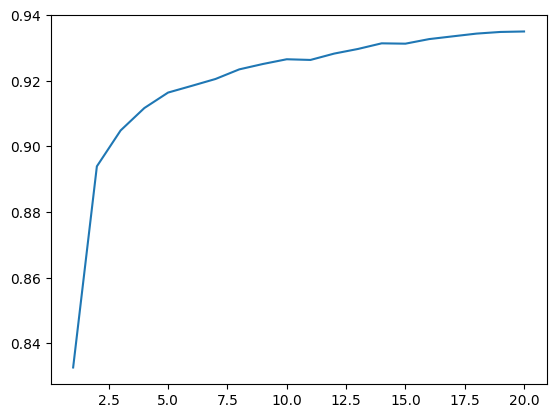

In [34]:
plt.plot(range(1, len(acc)+1), acc, label='Traiing Acc')

## Testing/using the model

We have to preprocess the image before inputting it to our model. We gonna use below module for it. Make sure to install them if not already installed.

In [40]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [35]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
MODEL_PATH = "genai_vs_original_model.keras"

The below function will preprocess the image and convert it into numpy array. This will the input to our model. This function will return the class of input image (GenAI or Original) and also the probability of the result.

In [ ]:
def predict_image(image_path):
    """
    Preprocess an input image and predict its class using the trained model.
    :param image_path: Path to the input image.
    :return: Predicted class label and probability.
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)
    class_label = "Original" if prediction[0][0] > 0.5 else "GenAI"
    probability = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    return class_label, probability

In [49]:
img_path = '/home/kirubakkar/Kiruba/Umich/Sem_1/Pattern_recognition_and_Neural_Networks/GenAI_Image_vs_Original_Image/Implementation/data/'

Below for loop will run predict function for few images.

In [57]:
for i in range(2,10):
    class_label, prob= predict_image(img_path+f'test/FAKE/2 ({i}).jpg')
    print(class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
GenAI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
GenAI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
GenAI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
GenAI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
GenAI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
GenAI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
GenAI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
GenAI


Now we'll use the test dataset we loaded using ImageDataGenerator class to test all our images from test directory.

In [ ]:
predictions = history.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)
true_labels = test_generator.classes
compare = predicted_classes == true_labels
worked = sum(compare)
failed = len(compare) - worked

print(f'Our model predicted {worked} images correctly and failed to predict {failed} images')